In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib
# import scipy
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy import stats
pd.options.mode.chained_assignment = None  # default='warn'
import scann
import math
import seaborn as sns

2022-10-20 16:37:20.677173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-20 16:37:20.937220: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/mesa-diverted/x86_64-linux-gnu:/usr/lib/x86_64-linux-gnu/mesa:/usr/lib/x86_64-linux-gnu/dri:/usr/lib/x86_64-linux-gnu/gallium-pipe
2022-10-20 16:37:20.937274: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-20 16:37:20.975713: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS facto

In [2]:
# trims a dataframe of outliers of the conditional distribution of y given x using fixed bin widths
def trimDF(df,x,y,percentiles,bins,binwidth):
    for i in range (len(bins)-1):
        data = df.loc[abs(df[x]-bins[i])<binwidth[i]]
        if not data.empty:
            df = df.drop(data.loc[(data[y]<np.percentile(data[y], percentiles[0]))].index.values)
            df = df.drop(data.loc[(data[y]>np.percentile(data[y], percentiles[1]))].index.values)
    return df



In [3]:
# trims a dataframe of outliers of the conditional distribution of y given x using fixed sample sizesd
def trimDFNumSample(df,x,y,percentiles,bins,numsamples):
    # sort DF by the x value to speed up subsetting
    dropList = []
    sortList = df.sort_values(by=x).reset_index()
    for i in bins:
        # find location of value nearest to current bin
        binIndex = sortList.loc[sortList[x]>i].index
        if not binIndex.empty:
            lenList = len(sortList)
            Sample = sortList.iloc[(np.maximum((binIndex[0]-100),0)):(np.minimum((binIndex[0]+100), lenList))]
            if not Sample.empty:
                dropList.append(Sample.loc[Sample[y]<np.percentile(Sample[y],percentiles[0])]['index'].values.tolist()) 
                dropList.append(Sample.loc[Sample[y]>np.percentile(Sample[y],percentiles[1])]['index'].values.tolist())
    return df.drop(sum(dropList,[]))


In [4]:
def scaleColumns(df, cols_to_scale):
    for col in cols_to_scale:
        df[col] = pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame(dfTest[col])),columns=[col])
    return df

In [5]:
def reduce_func(D_chunk, start):
    return np.histogram(D_chunk)

In [6]:
# does lars regression , displays path and returns results
def showLarsPath(X,y):
    
    alphas, active, coefs = linear_model.lars_path(X=X,y=y, method="lars", verbose=True)
    xx = np.sum(np.abs(coefs.T), axis=1)
    xx /= xx[-1]
    plt.plot(xx, coefs.T)
    ymin, ymax = plt.ylim(ylims)()
    plt.vlines(xx, ymin, ymax, linestyle="dashed")
    plt.xlabel("|coef| / max|coef|")
    plt.ylabel("Coefficients")
    plt.title("LASSO Path")
    plt.axis("tight")
    plt.show()
    
    return alphas, active, coefs

In [7]:
def parseSamples(directoryPath,fileSuffix):

    file_name = ['LUTinputLC0XB36', 'LUTinputLC0XB45','LUTinputMOD09' ,'LUTinputLC0XLat', \
                 'LUTinputLC0XLon','LUToutputLC0X','YearLC0X','MonthLC0X', \
                 'DayLC0X','PathLC0X','RowLC0X']

    dataset = []
    DataList = []
    count = 0

    for name in file_name:
        dataset.append(f'{directoryPath}{name}{fileSuffix}')

    for name_dataset in dataset:
        with open(f'{name_dataset}', 'rb') as fp1:
            objs = []
            while 1:
                try:
                    objs.append(pickle.load(fp1))
                except EOFError:
                    break
            DataList = [item for sublist in objs for item in sublist]

        if count == 0:
            LUTB36_list = DataList
        elif count == 1:
            LUTB45_list = DataList
        elif count == 2:
            LUTMOD09_list = DataList
        elif count == 3:
            LUTLat = DataList
        elif count == 4:
            LUTLon = DataList
        elif count == 5:
            LUToutput_list = DataList
        elif count == 6:
            LUTyear = DataList
        elif count == 7:
            LUTmonth = DataList
        elif count == 8:
            LUTday = DataList
        elif count == 9:
            LUTpath = DataList
        elif count == 10:
            LUTrow = DataList

        count = count + 1

    print('LUTB36_list:', len(LUTB36_list))
    print('LUTB45_list:', len(LUTB45_list))
    print('LUTMOD09_list:', len(LUTMOD09_list))
    print('LUTLat:', len(LUTLat))
    print('LUTLon:', len(LUTLon))
    print('LUToutput_list:', len(LUToutput_list))
    print('LUTyear:', len(LUTyear))
    print('LUTmonth:', len(LUTmonth))
    print('LUTday:', len(LUTday))
    print('LUTpath:', len(LUTpath))
    print('LUTrow:', len(LUTrow))

    # parse the LUTs into Pandas tables
    LUT_Lai = np.double(np.floor(np.mod(LUToutput_list,1e2)/1e0))
    LUT_LaiStdDev = np.double(np.floor(np.floor(np.mod(LUToutput_list,1e4)/1e2)))
    LUT_Fpar = np.double(np.floor(np.mod(LUToutput_list,1e6))/1e4)
    LUT_FparStdDev = np.double(np.floor(np.floor(np.mod(LUToutput_list,1e8)/1e6)))
    LUT_satFlag = np.uint64(np.floor(np.mod(LUToutput_list,1e11))/1e8)
    LUT_snowFlag = np.uint64(np.floor(np.floor(np.mod(LUToutput_list,1e14)/1e11)))
    LUT_LC_Type3 = np.uint64(np.floor(np.floor(np.mod(LUToutput_list,1e16)/1e14)))



    LUT_SR_B3 = np.double(np.floor(np.floor(np.mod(LUTB36_list,1e3)/1)))
    LUT_SR_B4 = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e3)/1)))

    LUT_SR_B5 = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e6)/1e3)))
    LUT_SR_B6 = np.double(np.floor(np.floor(np.mod(LUTB36_list,1e6)/1e3)))
    LUT_VIEW_ZENITH = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e8)/1e6)))
    LUT_VIEW_AZIMUTH = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e11)/1e8)))
    LUT_SUN_ELEVATION = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e13)/1e11)))
    LUT_SUN_AZIMUTH = np.double(np.floor(np.floor(np.mod(LUTB45_list,1e16)/1e13)))

    LUT_MOD09_red = np.double(np.floor(np.floor(np.mod(LUTMOD09_list,1e4)/1)))
    LUT_MOD09_NIR = np.double(np.floor(np.floor(np.mod(LUTMOD09_list,1e8)/1e4)))
    LUT_MSUN_ZENITH = np.uint64(np.floor(np.floor(np.mod(LUTMOD09_list,1e10)/1e8)))
    LUT_MSUN_AZIMUTH = np.uint64(np.floor(np.floor(np.mod(LUTMOD09_list,1e13)/1e10)))
    LUT_MVIEW_ZENITH = np.uint64(np.floor(np.floor(np.mod(LUTMOD09_list,1e15)/1e13)))
    LUT_MVIEW_AZIMUTH = np.uint64(np.floor(np.floor(np.mod(LUTMOD09_list,1e18)/1e15)))
    
    # make pandas frame of all coded inputs
    return pd.DataFrame( {'year':LUTyear, 'month': LUTmonth, 'day': LUTday, 'path':LUTpath, 'row':LUTrow,\
                          'Lat':LUTLat, 'Lon':LUTLon, 'input36': LUTB36_list,'input45':LUTB45_list, 'inputMOD09': LUTMOD09_list, 'redMODIS': LUT_MOD09_red,'NIRMODIS': LUT_MOD09_NIR,\
                          'green':LUT_SR_B3 * 10, 'red':LUT_SR_B4 * 10, 'NIR': LUT_SR_B5 * 10, 'SWIR1': LUT_SR_B6 * 10,   \
                          'SensorZenith':LUT_VIEW_ZENITH, 'SensorAzimuth': LUT_VIEW_AZIMUTH, 'SolarZenith':LUT_SUN_ELEVATION, 'SolarAzimuth': LUT_SUN_AZIMUTH, \
                          'M_sensor_zenith':LUT_MVIEW_ZENITH, 'M_sensor_azimuth': LUT_MVIEW_AZIMUTH, 'M_sun_zenith':LUT_MSUN_ZENITH, 'M_sun_azimuth': LUT_MSUN_AZIMUTH, \
                          'LC_type3': LUT_LC_Type3, 'output': LUToutput_list,'LAI': LUT_Lai, 'stdLAI': LUT_LaiStdDev, 'FAPAR': LUT_Fpar, 'stdFAPAR': LUT_FparStdDev,\
                          'LUT_satFlag': LUT_satFlag,'LUT_snowFlag': LUT_snowFlag,'LC_type3': LUT_LC_Type3}) \
               .sort_values('input36')

In [8]:
# trim calibration data based on comparing Landsat and MODIS equivalents
# note we oversample the MODIS axis as we trim
# this takes some time

def trimDF(df):

    # histogram NDVI vs LAI
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.hexbin(df['redMODIS'],df['red'], gridsize=(50,50), extent=(0,10000,0,10000))
    ax1.set(xlabel='redMODIS', ylabel='red')
    ax2.hexbin(df['NIRMODIS'],df['NIR'], gridsize=(50,50), extent=(0,10000,0,10000))
    ax2.set(xlabel='NIRMODIS', ylabel='NIR')
    plt.show()
    # threshold based on red MODIS
    df = df.drop(df.loc[(df['redMODIS']<100)].index.values)
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.hexbin(df['redMODIS'],df['red'], gridsize=(50,50), extent=(0,10000,0,10000))
    ax1.set(xlabel='redMODIS', ylabel='red')
    ax2.hexbin(df['NIRMODIS'],df['NIR'], gridsize=(50,50), extent=(0,10000,0,10000))
    ax2.set(xlabel='NIRMODIS', ylabel='NIR')
    plt.show()

    # trim based on red
    #df = trimDF(df,'redMODIS','red',[10,90],np.arange(0.0,1000.0,10),np.arange(0,1000,10)*0+20)
    df = trimDFNumSample(df,'redMODIS','red',[10,90],np.arange(100,1000.0,10),10000)
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.hexbin(df['redMODIS'],df['red'], gridsize=(50,50), extent=(0,10000,0,10000))
    ax1.set(xlabel='redMODIS', ylabel='red')
    ax2.hexbin(df['NIRMODIS'],df['NIR'], gridsize=(50,50), extent=(0,10000,0,10000))
    ax2.set(xlabel='NIRMODIS', ylabel='NIR')
    plt.show()
    #trim based on nir
    #df = trimDF(df,'NIRMODIS','NIR',[10,90],np.arange(0.0,10000.0,100),np.arange(0,10000,100)*0+200)
    df = trimDFNumSample(df,'NIRMODIS','NIR',[10,90],np.arange(100,1000.0,10),10000)
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.hexbin(df['redMODIS'],df['red'], gridsize=(50,50), extent=(0,10000,0,10000))
    ax1.set(xlabel='redMODIS', ylabel='red')
    ax2.hexbin(df['NIRMODIS'],df['NIR'], gridsize=(50,50), extent=(0,10000,0,10000))
    ax2.set(xlabel='NIRMODIS', ylabel='NIR')
    plt.show()
    
    #trim based on nir
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.hexbin(df['redMODIS'],df['LAI'], gridsize=(50,50), extent=(0,10000,0,100))
    ax1.set(xlabel='redMODIS', ylabel='LAI')
    ax2.hexbin(df['NIRMODIS'],df['LAI'], gridsize=(50,50), extent=(0,10000,0,100))
    ax2.set(xlabel='NIRMODIS', ylabel='LAI')
    plt.show()
    return df

In [296]:
# plots hoistograms of all estimators for raw bands and augmented bands
def plotHistResults(df,xlims,ylims,tval,bwidth):
    fig, axes = plt.subplots(2,4)
    fig.set_figheight(20)
    fig.set_figwidth(20)
    

    predictions = np.array(df['knnRawLAI'])
    targets = np.array(df['LAI'])
    print(np.sqrt(np.mean((predictions-targets)**2)))
    sns.histplot(ax=axes[0,0],
        data=df, x='knnRawLAI', y='LAI',
        bins=30, discrete=(False, False), log_scale=(False, False),
        thresh=tval,binwidth=bwidth
    )
    axes[0,0].plot(xlims,ylims)
    axes[0,0].set_xlim(xlims)
    axes[0,0].set_ylim(ylims)


    predictions = np.array(df['mlpRawLAI'])
    targets = np.array(df['LAI'])
    print(np.sqrt(np.mean((predictions-targets)**2)))
    sns.histplot(ax=axes[0,1],
         data=df, x='mlpRawLAI', y='LAI',
        bins=30, discrete=(False, False), log_scale=(False, False),
        thresh=tval,binwidth=bwidth
    )
    axes[0,1].plot(xlims,ylims)
    axes[0,1].set_xlim(xlims)
    axes[0,1].set_ylim(ylims)


    predictions = np.array(df['rf1RawLAI'])
    targets = np.array(df['LAI'])
    print(np.sqrt(np.mean((predictions-targets)**2)))
    sns.histplot(ax=axes[0,2],
         data=df, x='rf1RawLAI', y='LAI',
        bins=30, discrete=(False, False), log_scale=(False, False),
        thresh=tval,binwidth=bwidth
    )
    axes[0,2].plot(xlims,ylims)
    axes[0,2].set_xlim(xlims)
    axes[0,2].set_ylim(ylims)

    predictions = np.array(df['rf1RawLAIW'])
    targets = np.array(df['LAI'])
    print(np.sqrt(np.mean((predictions-targets)**2)))
    sns.histplot(ax=axes[0,3],
         data=df, x='rf1RawLAIW', y='LAI',
        bins=30, discrete=(False, False), log_scale=(False, False),
        thresh=tval,binwidth=bwidth
    )
    axes[0,3].plot(xlims,ylims)
    axes[0,3].set_xlim(xlims)
    axes[0,3].set_ylim(ylims)
    
    predictions = np.array(df['knnAllLAI'])
    targets = np.array(df['LAI'])
    print(np.sqrt(np.mean((predictions-targets)**2)))
    sns.histplot(ax=axes[1,0],
        data=df, x='knnAllLAI', y='LAI',
        bins=30, discrete=(False, False), log_scale=(False, False),
        thresh=tval,binwidth=bwidth
    )
    axes[1,0].plot(xlims,ylims)
    axes[1,0].set_xlim(xlims)
    axes[1,0].set_ylim(ylims)


    predictions = np.array(df['mlpAllLAI'])
    targets = np.array(df['LAI'])
    print(np.sqrt(np.mean((predictions-targets)**2)))
    sns.histplot(ax=axes[1,1],
         data=df, x='mlpAllLAI', y='LAI',
        bins=30, discrete=(False, False), log_scale=(False, False),
        thresh=tval,binwidth=bwidth
    )
    axes[1,1].plot(xlims,ylims)
    axes[1,1].set_xlim(xlims)
    axes[1,1].set_ylim(ylims)


    predictions = np.array(df['rf1AllLAI'])
    targets = np.array(df['LAI'])
    print(np.sqrt(np.mean((predictions-targets)**2)))
    sns.histplot(ax=axes[1,2],
         data=df, x='rf1AllLAI', y='LAI',
        bins=30, discrete=(False, False), log_scale=(False, False),
        thresh=tval,binwidth=bwidth
    )
    axes[1,2].plot(xlims,ylims)
    axes[1,2].set_xlim(xlims)
    axes[1,2].set_ylim(ylims)

    predictions = np.array(df['rf1AllLAIW'])
    targets = np.array(df['LAI'])
    print(np.sqrt(np.mean((predictions-targets)**2)))
    sns.histplot(ax=axes[1,3],
         data=df, x='rf1AllLAIW', y='LAI',
        bins=30, discrete=(False, False), log_scale=(False, False),
        thresh=tval,binwidth=bwidth
    )
    axes[1,3].plot(xlims,ylims)
    axes[1,3].set_xlim(xlims)
    axes[1,3].set_ylim(ylims)
    
    plt.show()
    return

In [ ]:
def makeFeatures(df):

    df['green1'] = np.clip((df.loc[:,"green"]),0,3000)/10000
    df['red1'] = np.clip((df.loc[:,"red"]),0,4000)/10000
    df['NIR1'] = np.clip((df.loc[:,"NIR"]),0,6000)/10000
    df['SWIR11'] = np.clip((df.loc[:,"SWIR1"]),0,6000)/10000
    df['ISR'] = np.clip((df.loc[:,"NIR1"])/np.maximum(df.loc[:,"SWIR11"],.0001),0,3)
    df['SR'] = np.clip((df.loc[:,"NIR1"])/np.maximum(df.loc[:,"red1"],.0001),0,20)
    df['GI'] = np.clip((df.loc[:,"green"])/np.maximum(df.loc[:,"red"],.0001),0,3)
    df['GVI'] = np.clip((df.loc[:,"NIR"])/np.maximum(df.loc[:,"green"]-1,.0001),0,20)
    df['NDVI'] = np.clip(((df.loc[:,"NIR"])-(df.loc[:,"red"]))/np.maximum(((df.loc[:,"NIR"])+(df.loc[:,"red"])),.0001),0,+1)
    df['GNDVI'] = np.clip(((df.loc[:,"NIR"])-(df.loc[:,"green"]))/np.maximum(((df.loc[:,"NIR"])+(df.loc[:,"green"])),.0001),0,+1)
    df['NDWI'] = np.clip(((df.loc[:,"NIR"])-(df.loc[:,"SWIR1"]))/np.maximum(((df.loc[:,"NIR"])+(df.loc[:,"SWIR1"])),.0001),0,+1)
    df['NDGI'] = np.clip(((df.loc[:,"green"])-(df.loc[:,"red"]))/np.maximum(((df.loc[:,"green"])+(df.loc[:,"red"])),.0001),0,+1)       
    df['EVI'] = np.clip((2.5*((df.loc[:,"NIR"])-(df.loc[:,"red"]))/np.maximum((df.loc[:,"NIR"])+6*(df.loc[:,"red"])-7.5*(df.loc[:,"green"])+1,.0001)),0,+1)
    df['EVI2'] = np.clip(2.5*((df.loc[:,"NIR"])-(df.loc[:,"red"]))/np.maximum(((df.loc[:,"NIR"])+2.4*(df.loc[:,"red"])+1),.0001),0,+1)
    df['RDVI'] = np.clip(((df.loc[:,"NIR"])-(df.loc[:,"red"]))/np.maximum(((df.loc[:,"NIR"])+(df.loc[:,"red"]))**0.5,.0001),0,+1)
    df['MSR'] = np.clip((((df.loc[:,"NIR"])/(np.maximum(df.loc[:,"red"],0.0001)))-1)/np.maximum((np.maximum((df.loc[:,"NIR"])/np.maximum(df.loc[:,"red"],0.0001),0.0001)**0.5+1),.0001),0,+1)
    df['MSAVI2'] = np.clip(0.5*(((df.loc[:,"NIR"])+1)-np.maximum((2*(df.loc[:,"NIR"])+1)**2-8*(df.loc[:,"NIR"])-(df.loc[:,"red"]),0.0001)**0.5),0,+1)
    df['NLI'] =np.clip(((df.loc[:,"NIR"])**2-(df.loc[:,"red"]))/np.maximum(((df.loc[:,"NIR"])**2+(df.loc[:,"red"])),.0001),0,+1)
    return df

LUTB36_list: 6792058
LUTB45_list: 6792058
LUTMOD09_list: 6792058
LUTLat: 6792058
LUTLon: 6792058
LUToutput_list: 6792058
LUTyear: 6792058
LUTmonth: 6792058
LUTday: 6792058
LUTpath: 6792058
LUTrow: 6792058


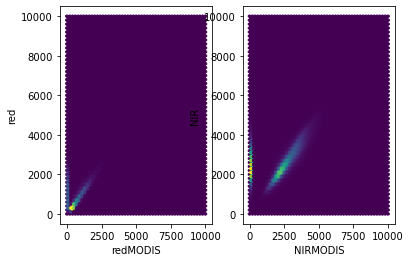

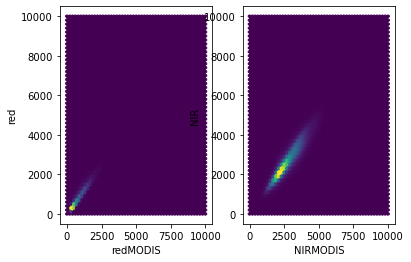

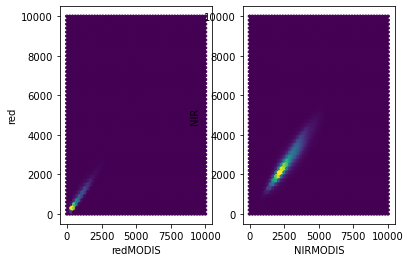

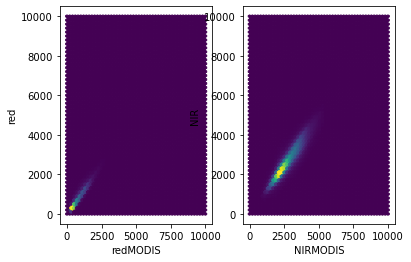

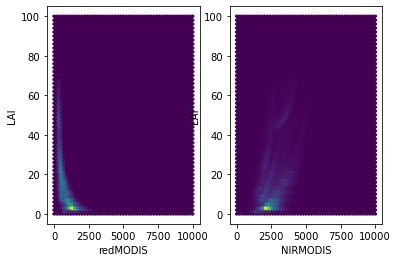

(1148920, 32)


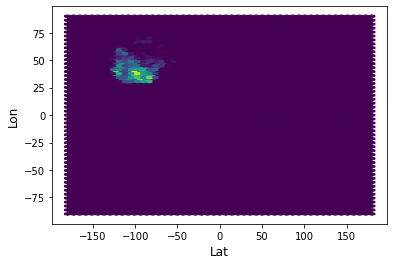

In [315]:
directoryPath  = '/home/richard_fernandes/modislandsat/Calibrationv5/NorthAmerica/'
fileSuffix = 'calv7'
calDFALL = parseSamples(directoryPath ,fileSuffix)
calDFALL = calDFALL[(calDFALL.red < 5000) & (calDFALL.green > 0 ) & (calDFALL.red >0) & (calDFALL.NIR > 0 ) & (calDFALL.SWIR1 < 5000)& (calDFALL.M_sensor_zenith<20)]
calDFALL = trimDF(calDFALL)
print(calDFALL.shape)
plt.hexbin(calDFALL['Lon'],calDFALL['Lat'], gridsize=(50,50), extent=(-180,180,-90,90))
plt.xlabel('Lat',size = 12)
plt.ylabel('Lon',size = 12)
plt.show()

LUTB36_list: 7012604
LUTB45_list: 7012604
LUTMOD09_list: 7012604
LUTLat: 7012604
LUTLon: 7012604
LUToutput_list: 7012604
LUTyear: 7012604
LUTmonth: 7012604
LUTday: 7012604
LUTpath: 7012604
LUTrow: 7012604
(1629666, 32)


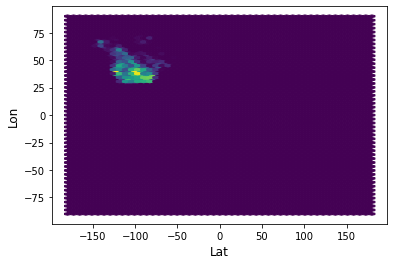

In [333]:
directoryPath  = '/home/richard_fernandes/modislandsat/Validationv5/NorthAmerica/'
fileSuffix = 'calv9'
valDFALL = parseSamples(directoryPath ,fileSuffix)
valDFALL = valDFALL[(valDFALL.red < 5000) & (valDFALL.green > 0 ) & (valDFALL.red >0) & (valDFALL.NIR > 0 ) & (valDFALL.SWIR1 < 5000) & (valDFALL.M_sensor_zenith<20)]\
#ensure val and cal DF are different
# df_all = valDFALL.merge(calDFALL.drop_duplicates(), on=valDFALL.columns, how='left', indicator=True)
# valDFALL = df_all[df_all['_merge'] == 'left_only']
# valDFALL = trimDF(valDFALL)
print(valDFALL.shape)
plt.hexbin(valDFALL['Lon'],valDFALL['Lat'], gridsize=(50,50), extent=(-180,180,-90,90))
plt.xlabel('Lat',size = 12)
plt.ylabel('Lon',size = 12)
plt.show()

In [334]:
# make features of all data
calDFALL = makeFeatures(calDFALL)
valDFALL = makeFeatures(valDFALL)

(117961, 50)
(145162, 50)


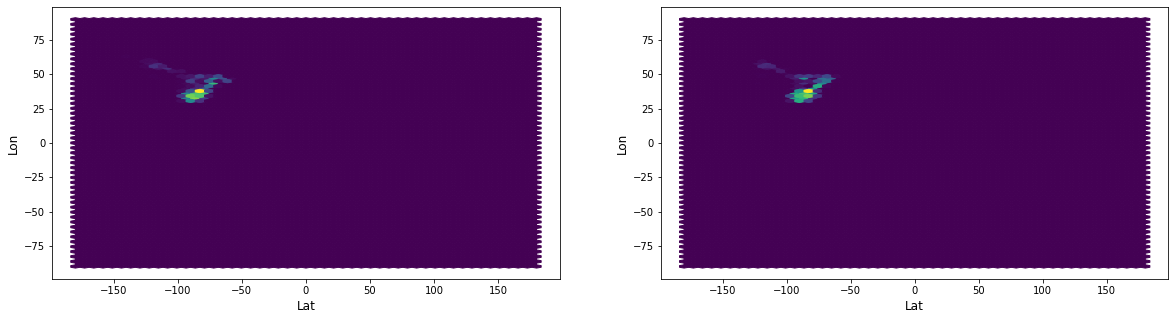

In [335]:
calDF6 = calDFALL[calDFALL['LC_type3']==6]
print(calDF6.shape)
valDF6 = valDFALL[valDFALL['LC_type3']==6]
print(valDF6.shape)

fig,ax = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(20)
ax[0].hexbin(valDF6['Lon'],valDF6['Lat'], gridsize=(50,50), extent=(-180,180,-90,90))
ax[0].set_xlabel('Lat',size = 12)
ax[0].set_ylabel('Lon',size = 12)

ax[1].hexbin(calDF6['Lon'],calDF6['Lat'], gridsize=(50,50), extent=(-180,180,-90,90))
ax[1].set_xlabel('Lat',size = 12)
ax[1].set_ylabel('Lon',size = 12)
plt.show()

(105235, 50)
(147623, 50)


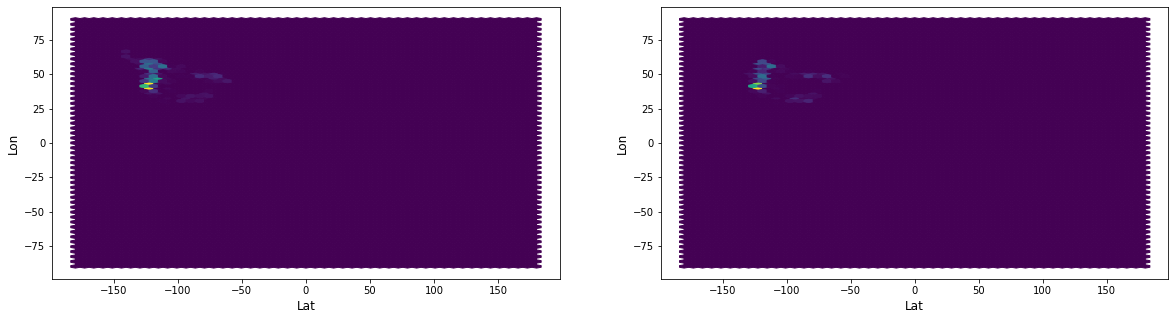

In [336]:
calDF7 = calDFALL[calDFALL['LC_type3']==7]
print(calDF7.shape)
valDF7 = valDFALL[valDFALL['LC_type3']==7]
print(valDF7.shape)

fig,ax = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(20)
ax[0].hexbin(valDF7['Lon'],valDF7['Lat'], gridsize=(50,50), extent=(-180,180,-90,90))
ax[0].set_xlabel('Lat',size = 12)
ax[0].set_ylabel('Lon',size = 12)

ax[1].hexbin(calDF7['Lon'],calDF7['Lat'], gridsize=(50,50), extent=(-180,180,-90,90))
ax[1].set_xlabel('Lat',size = 12)
ax[1].set_ylabel('Lon',size = 12)
plt.show()

In [337]:
allfeatures=  ['SR', 'ISR', 'green1', 'red1', 'NIR1', 'SWIR11', 'GI', 'GVI','NDVI','GNDVI','NDWI','NDGI','EVI','EVI2','RDVI','MSR','MSAVI2','NLI']
rawfeatures = ['green1', 'red1', 'NIR1', 'SWIR11']
response= ['LAI']

In [338]:
# fit models and make predictions for calibration and validation data
calDF = calDF7
scalerDF = MinMaxScaler().fit(calDF[allfeatures])
calDF[allfeatures] = pd.DataFrame(scalerDF.transform(calDF[allfeatures]),columns = calDF[allfeatures].columns, index =calDF[allfeatures].index) 

valDF = valDF7
valDF[allfeatures] = pd.DataFrame(scalerDF.transform(valDF[allfeatures]),columns = valDF[allfeatures].columns, index =valDF[allfeatures].index) 

# k NN regression 
knnRegressionModelRaw = neighbors.KNeighborsRegressor(n_neighbors=10,weights='distance',algorithm='ball_tree').fit(calDF[rawfeatures],calDF[response])
calDF['knnRawLAI']= knnRegressionModelRaw.predict(calDF[rawfeatures])
valDF['knnRawLAI']= knnRegressionModelRaw.predict(valDF[rawfeatures])

knnRegressionModelAll = neighbors.KNeighborsRegressor(n_neighbors=10,weights='distance',algorithm='ball_tree').fit(calDF[allfeatures], calDF[response])
calDF['knnAllLAI']= knnRegressionModelAll.predict(calDF[allfeatures])
valDF['knnAllLAI']= knnRegressionModelAll.predict(valDF[allfeatures])

#neural network 
mlpRAW = MLPRegressor(hidden_layer_sizes=(20,20),random_state=1, max_iter=500).fit(calDF[rawfeatures], np.array(calDF[response]).ravel())
calDF['mlpRawLAI']=mlpRaw.predict(calDF[rawfeatures])
valDF['mlpRawLAI']=mlpRaw.predict(valDF[rawfeatures])

mlpAll = MLPRegressor(hidden_layer_sizes=(20,20),random_state=1, max_iter=500).fit(calDF[allfeatures], np.array(calDF[response]).ravel())
calDF['mlpAllLAI']=mlpAll.predict(calDF[allfeatures])
valDF['mlpAllLAI']=mlpAll.predict(valDF[allfeatures])

#random forest 
rfRaw = RandomForestRegressor(n_estimators=100,min_samples_leaf=10,bootstrap=True,random_state=0,verbose=0,max_leaf_nodes=10000).fit(calDF[rawfeatures], np.array(calDF[response]).ravel())
calDF['rf1RawLAI']=rfRaw.predict(calDF[rawfeatures])
valDF['rf1RawLAI']=rfRaw.predict(valDF[rawfeatures])

rfAll = RandomForestRegressor(n_estimators=100,min_samples_leaf=10,bootstrap=True,random_state=0,verbose=0,max_leaf_nodes=10000).fit(calDF[allfeatures], np.array(calDF[response]).ravel())
calDF['rf1AllLAI']=rfAll.predict(calDF[allfeatures])
valDF['rf1AllLAI']=rfAll.predict(valDF[allfeatures])

#weighted random forest
#get weights from knn
# k NN regression 
knnRegressionModelRaw = neighbors.KNeighborsRegressor(n_neighbors=10,weights='distance',algorithm='ball_tree').fit(calDF[rawfeatures],calDF[response])
neigh_dist, neigh_ind = knnRegressionModelRaw.kneighbors(calDF[rawfeatures],n_neighbors=10, return_distance=True)
calDF['weights'] = 1000*(np.amax(neigh_dist,1)**4)/np.sum((np.amax(neigh_dist,1)**4))
rfRaw = RandomForestRegressor(n_estimators=100,min_samples_leaf=10,bootstrap=True,random_state=0,verbose=0,max_leaf_nodes=10000).fit(calDF[rawfeatures], np.array(calDF[response]).ravel(),np.array(calDF['weights']).ravel())
calDF['rf1RawLAIW']=rfRaw.predict(calDF[rawfeatures])
valDF['rf1RawLAIW']=rfRaw.predict(valDF[rawfeatures])

rfAll = RandomForestRegressor(n_estimators=100,min_samples_leaf=10,bootstrap=True,random_state=0,verbose=0,max_leaf_nodes=10000).fit(calDF[allfeatures], np.array(calDF[response]).ravel(),np.array(calDF['weights']).ravel())
calDF['rf1AllLAIW']=rfAll.predict(calDF[allfeatures])
valDF['rf1AllLAIW']=rfAll.predict(valDF[allfeatures])



calDF7 = valDF
valDF7 = valDF

9.790717617003324
13.778598829192454
9.407711339369898
9.403357596595944
9.86402070699503
9.274419753863596
9.409400053035892
9.387778358597403


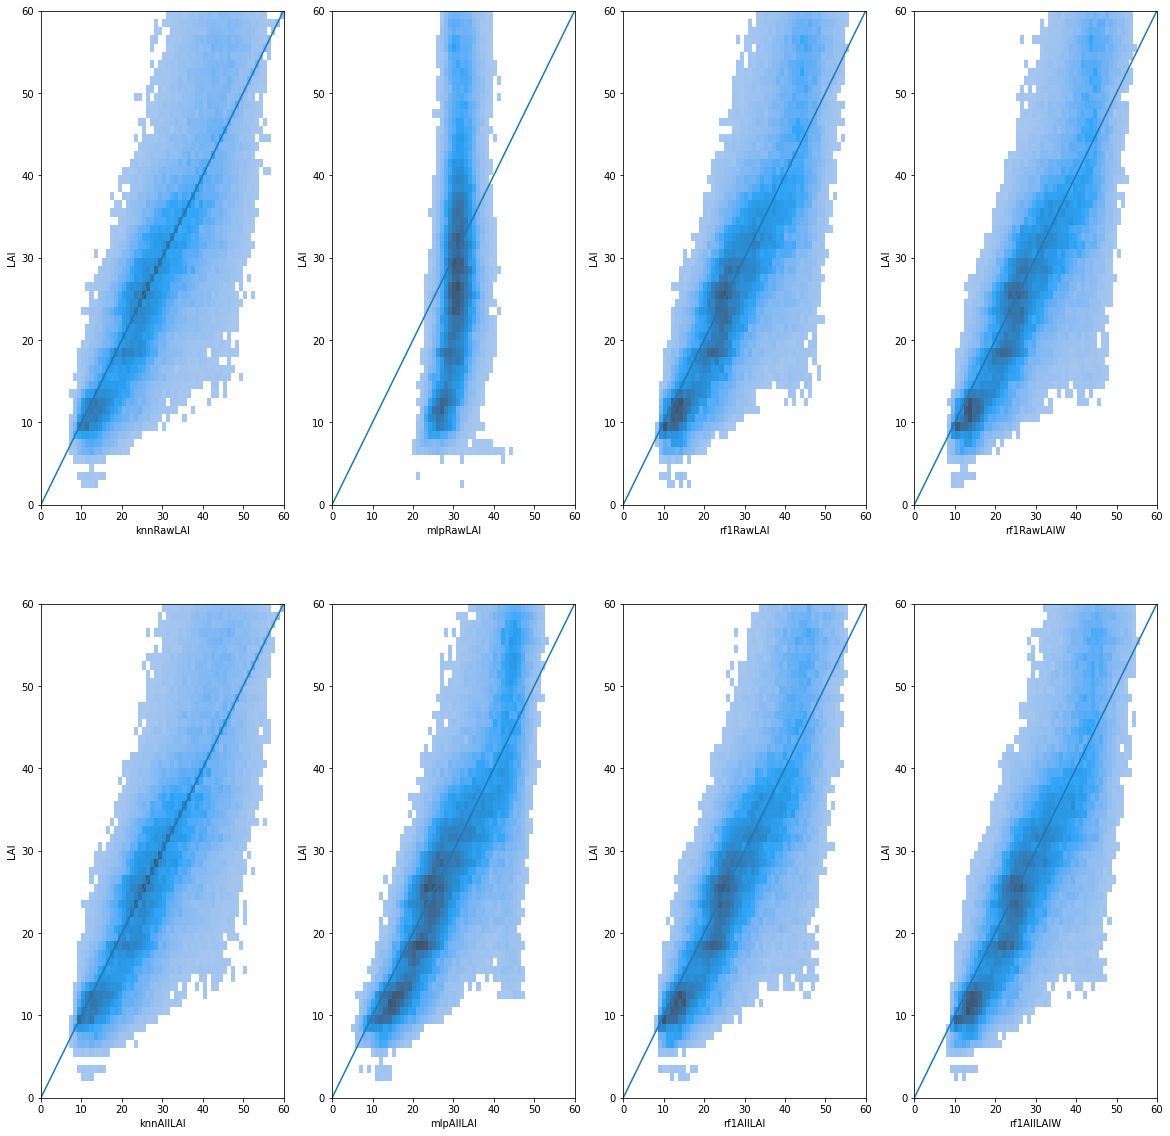

In [339]:
plotHistResults(valDF,(0,60),(0,60),tval=10,bwidth=1)

In [ ]:
#iterative estimates - this part of code has not been integrated yet (RF)
calDF = calDF7
scalerDF = MinMaxScaler().fit(calDF[allfeatures])
calDF[alleatures] = pd.DataFrame(scalerDF.transform(calDF[allfeatures]),columns = calDF[allfeatures].columns, index =calDF[allfeatures].index) 

valDF = valDF7
valDF[allfeatures] = pd.DataFrame(scalerDF.transform(valDF[allfeatures]),columns = valDF[allfeatures].columns, index =valDF[allfeatures].index) 


# uniform sub sample and get lars features 
maxClasses=10
numLARSFeatures=4
maxSamples=10000
percentilePairwiseDist=99
metricDist='euclidean'
randSeed=1 
subSampleDF = subsampleSobol(calDF,allfeatures ,maxSamples,percentilePairwiseDist,metricDist,randSeed)
alphas, active, coefs = showLarsPath(subSampleDF[allfeatures].to_numpy(),subSampleDF[response].to_numpy())
featuresLARS = [allfeatures[i] for i in np.uint64(np.where(abs(coefs[:,numLARSFeatures])>0))[0]]
print(featuresLARS)

# do kmeans on the lars subset and visualize
kmeans = KMeans(n_clusters=numClasses, random_state=0).fit(subSampleDF[featuresLARS])
plt.hexbin(subSampleDF[featuresLARS[0]],subSampleDF[featuresLARS[1]], gridsize=(50,50), extent=(0,1,0,1))
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='y')
plt.xlabel(featuresLARS[0],size = 12)
plt.ylabel(featuresLARS[1],size = 12)
plt.title('Scaled LARS Feature Space with Uniform Samples and k-Means Centroids')
plt.show() 

plt.hexbin(subSampleDF[featuresLARS[0]],subSampleDF[featuresLARS[1]], gridsize=(50,50), extent=(0,1,0,1))
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='y')
plt.xlabel(featuresLARS[0],size = 12)
plt.ylabel(featuresLARS[1],size = 12)
plt.title('Scaled LARS Feature Space with Original Samples and k-Means Centroids')
plt.show() 

# label allsamples by cluster which can now be treated as inputs for each tree
# ideallyy we would add in a bit of adjacent cluster - not sure how to do this easily
calDF['classKmeans'] = kmeans.predict(calDF[featuresLARS[i]])
valDF['classKmeans'] = kmeans.predict(valDF[featuresLARS[i]])

seaborn.scatterplot(data=calDF,x='SR',y='SWIR1',hue='classKmeans',palette="Spectral")
plt.show()

# make a regression tree for each cluster and predict (for now no testing dataset ... )
# we assume for now each cluster sufficiently uniform and we use all VIs
# we coyuld always resort to lars or both but a RF is generally robust to lots of features 
YY = []
yy = []
for i in range(1,numClasses):
    X = calDF.loc[calDF['classKmeans']==classValues[i],rawfeatures]
    y = np.ravel(np.array(calDF.loc[calDF['class']==classValues[i],response]))
    clf = RandomForestRegressor(random_state=0).fit(X,y)
    print(clf.score(X,y))
    X = valDF.loc[valDF['classKmeans']==classValues[i],rawfeatures]
    y = np.ravel(np.array(valDF.loc[valDF['class']==classValues[i],response]))
    YY.append(clf.predict(X))
    yy.append(y)
YY = [item for sublist in YY for item in sublist]
yy = [item for sublist in yy for item in sublist]
RMSE = np.sqrt(np.square(np.subtract(yy,YY)).mean())
print('RMSE =', RMSE)
plt.hexbin(YY, yy, gridsize=(50,50))
plt.xlabel('estimated LAI',size = 12)
plt.ylabel('LAI',size = 12)
plt.show()      

RMSE_list.append(RMSE)


In [101]:
# sets up a Sobol sampling grid and finds one match in df within a distance of each Sobol grid sample
def sobolSampler(df,featureColumns,randSeed,pairwiseDist):
    
    # sobol sampling with number of samples determined by https://www.sciencedirect.com/science/article/abs/pii/S0378475406002382
    nsam = np.power(pairwiseDist,-len(featureColumns))
    M = min(20,np.uint8(np.ceil(np.log2(nsam))))
    print('number of sobol points',pow(2,M))
    sobel = scipy.stats.qmc.Sobol(len(featureColumns),seed=randSeed).random_base2(m=M)
    
    # match sobol samples to our data
    #distances,indices = neighbors.NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(df[featureColumns]).kneighbors(sobel)
    indices, distances = ScaNN(df[featureColumns],sobel,k=1,numleaves=math.ceil(pow(pow(2,M),0.5)),numleavestosearch=100,anisotropicquantizationthreshold=0.2,reorderSize=100)


    return df.iloc[np.unique(np.array(indices).ravel())]


In [75]:
def ScaNN(train,test,k,numleaves,numleavestosearch,anisotropicquantizationthreshold,reorderSize) :

    # use scann.scann_ops.build() to instead create a TensorFlow-compatible searcher
    searcher = scann.scann_ops_pybind.builder(train, 1, "squared_l2").tree(
        num_leaves=numleaves,num_leaves_to_search=numleavestosearch, training_sample_size=train.shape[0]).score_ah(
        2, anisotropic_quantization_threshold=anisotropicquantizationthreshold).reorder(reorderSize).build()
    
    return searcher.search_batched(test)
    
    

In [76]:
# get pairwise distances between rows in data frame
def getPairwiseDist(df,maxSamples, metricDist):
    
    nsam = min(maxSamples,df.shape[0])
    di = pairwise_distances(df.sample(nsam),metric=metricDist)
    
    return np.amin(di+np.diag(np.ones(di.shape[0])+100),axis=1)
    

In [77]:
#subsamples df based on uniform Sobol sampling of featurecolumns with spacing defined by percentilePairwiseDist
def subsampleSobol(df,featureColumns,maxSamples,percentilePairwiseDist,metricDist,randSeed):
    
    return sobolSampler(df,featureColumns,randSeed,np.percentile(getPairwiseDist(df[featureColumns],maxSamples, metricDist),percentilePairwiseDist))

100000


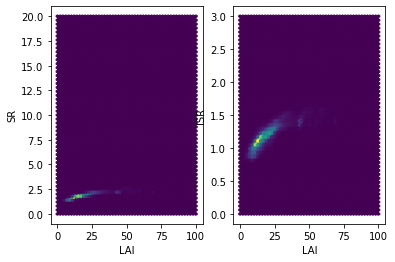

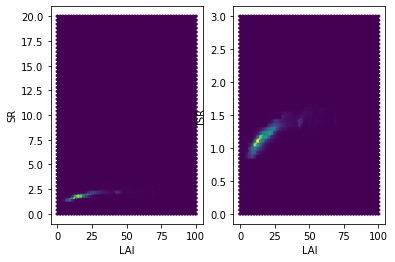

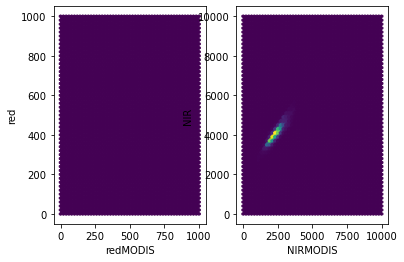

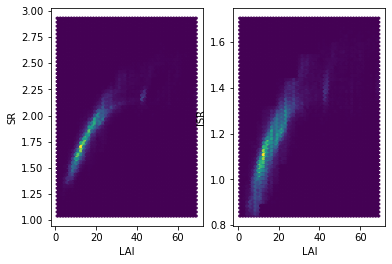

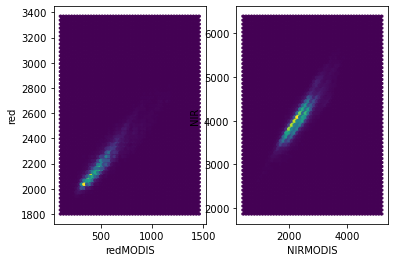

df size (96232, 51)
scaled df size (96232, 51)
number of sobol points 1048576


2022-10-19 22:51:41.633268: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 96232
2022-10-19 22:51:42.121613: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:88] PartitionerFactory ran in 488.235409ms.


.

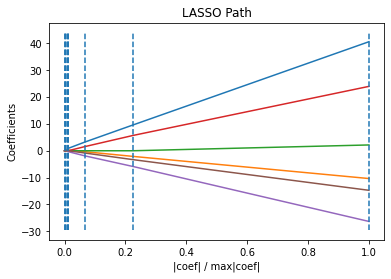

['SR', 'ISR', 'NIR1']
lars df size (12875, 51)


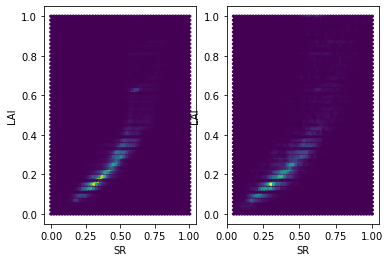

In [125]:
# process each biome type separately
response = 'LAI'
for LC_type3 in [6]: #df["LC_type3"].drop_duplicates():
    #subset sample
    sample_full = df[df["LC_type3"]==LC_type3]

# only few samples are used to run
    sample = sample_full.head(min(sample_full.shape[0],100000))
    print(len(sample))
    
    # add ISR and SR 
    sample['ISR'] = np.clip((sample.loc[:,"NIR"])/np.maximum(sample.loc[:,"SWIR1"],1),0,3)
    sample['SR'] = np.clip((sample.loc[:,"NIR"])/np.maximum(sample.loc[:,"red"],1),0,20)
   
    
    # trim based on LAI vs VIs
    # we oversample in LAI
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.hexbin(sample[response],sample['SR'], gridsize=(50,50), extent=(0,100,0,20))
    ax1.set(xlabel=response, ylabel='SR')
    ax2.hexbin(sample[response],sample['ISR'], gridsize=(50,50), extent=(0,100,0,3))
    ax2.set(xlabel=response, ylabel='ISR')
    df = trimDF(sample,response,'SR',[1,99],np.arange(0.0,100.0,10),np.arange(0,100,10)*0+10)
    df = trimDF(sample,response,'ISR',[1,99],np.arange(0.0,100.0,10),np.arange(0,100,10)*0+10)
    
    # see results 
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.hexbin(df[response],df['SR'], gridsize=(50,50), extent=(0,100,0,20))
    ax1.set(xlabel=response, ylabel='SR')
    ax2.hexbin(df[response],df['ISR'], gridsize=(50,50), extent=(0,100,0,3))
    ax2.set(xlabel=response, ylabel='ISR')
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.hexbin(df['redMODIS'],df['red'], gridsize=(50,50), extent=(0,1000,0,1000))
    ax1.set(xlabel='redMODIS', ylabel='red')
    ax2.hexbin(df['NIRMODIS'],df['NIR'], gridsize=(50,50), extent=(0,10000,0,10000))
    ax2.set(xlabel='NIRMODIS', ylabel='NIR')   
    
#     # add a lot of VIs 
#    listVI = ['SR', 'ISR'] 
    listVI = ['SR', 'ISR', 'green1', 'red1', 'NIR1', 'SWIR11', 'GI', 'GVI','NDVI','GNDVI','NDWI','NDGI','NDVI3','EVI','EVI2','RDVI','MSR','MSAVI2','NLI']
    listVI = ['SR', 'ISR', 'green1', 'red1', 'NIR1', 'SWIR11']

    df['green1'] = np.clip((df.loc[:,"green"]),0,3000)
    df['red1'] = np.clip((df.loc[:,"red"]),0,4000)
    df['NIR1'] = np.clip((df.loc[:,"NIR"]),0,6000)
    df['SWIR11'] = np.clip((df.loc[:,"SWIR1"]),0,6000)
    df['GI'] = np.clip((df.loc[:,"green"])/np.maximum(df.loc[:,"red"],1),0,3)
    df['GVI'] = np.clip((df.loc[:,"NIR"])/np.maximum(df.loc[:,"green"]-1,1),0,20)
    df['NDVI'] = np.clip(((df.loc[:,"NIR"])-(df.loc[:,"red"]))/np.maximum(((df.loc[:,"NIR"])+(df.loc[:,"red"])),1),0,+1)
    df['GNDVI'] = np.clip(((df.loc[:,"NIR"])-(df.loc[:,"green"]))/np.maximum(((df.loc[:,"NIR"])+(df.loc[:,"green"])),1),0,+1)
    df['NDWI'] = np.clip(((df.loc[:,"NIR"])-(df.loc[:,"SWIR1"]))/np.maximum(((df.loc[:,"NIR"])+(df.loc[:,"SWIR1"])),1),0,+1)
    df['NDGI'] = np.clip(((df.loc[:,"green"])-(df.loc[:,"red"]))/np.maximum(((df.loc[:,"green"])+(df.loc[:,"red"])),1),0,+1)       
    df['NDVI3'] = np.clip(((df.loc[:,"NIR"])-(df.loc[:,"red"]))/np.maximum((df.loc[:,"NIR"]),1)+(df.loc[:,"red"]),-1,+1)
    df['EVI'] = np.clip((2.5*((df.loc[:,"NIR"])-(df.loc[:,"red"]))/np.maximum((df.loc[:,"NIR"]),1)+6*(df.loc[:,"red"])-7.5*(df.loc[:,"green"])+1),0,+1)
    df['EVI2'] = np.clip(2.5*((df.loc[:,"NIR"])-(df.loc[:,"red"]))/np.maximum(((df.loc[:,"NIR"])+2.4*(df.loc[:,"red"])+1),1),0,+1)
    df['RDVI'] = np.clip(((df.loc[:,"NIR"])-(df.loc[:,"red"]))/np.maximum(((df.loc[:,"NIR"])+(df.loc[:,"red"]))**0.5,1),0,+1)
    df['MSR'] = np.clip((((df.loc[:,"NIR"])/(df.loc[:,"red"]))-1)/np.maximum((((df.loc[:,"NIR"])/(df.loc[:,"red"]))**0.5+1),1),0,+1)
    df['MSAVI2'] = np.clip(0.5*(((df.loc[:,"NIR"])+1)-((2*(df.loc[:,"NIR"])+1)**2-8*(df.loc[:,"NIR"])-(df.loc[:,"red"]))**0.5),0,+1)
    df['NLI'] =np.clip(((df.loc[:,"NIR"])**2-(df.loc[:,"red"]))/np.maximum(((df.loc[:,"NIR"])**2+(df.loc[:,"red"])),1),0,+1)
    

 
    # see results
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.hexbin(df[response],df['SR'], gridsize=(50,50))
    ax1.set(xlabel=response, ylabel='SR')
    ax2.hexbin(df[response],df['ISR'], gridsize=(50,50))
    ax2.set(xlabel=response, ylabel='ISR')
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.hexbin(df['redMODIS'],df['red'], gridsize=(50,50))
    ax1.set(xlabel='redMODIS', ylabel='red')
    ax2.hexbin(df['NIRMODIS'],df['NIR'], gridsize=(50,50))
    ax2.set(xlabel='NIRMODIS', ylabel='NIR')  
    plt.show()

    # df['class'] = clusterLARSSobel(df=df,response='LAI', maxClasses=10, features=listVI,numLARSFeatures=4, maxSamples=10000,percentilePairwiseDist=99,metricDist='euclidean',randSeed=1) 

    df=df
    response='LAI'
    maxClasses=10
    features=listVI
    numLARSFeatures=4
    maxSamples=10000
    percentilePairwiseDist=99
    metricDist='euclidean'
    randSeed=1 
    
    print('df size', df.shape)
    # standardize or rescale the data (probably rescale based on 1,99 %ile range since data is skewed)
    scalerDF = MinMaxScaler().fit(df)
    scaledDF= pd.DataFrame(scalerDF.transform(df),columns = df.columns, index =df.index)
    print('scaled df size', scaledDF.shape)
    
    # uniform sub sample and get lars features 
    subSampleDF = subsampleSobol(scaledDF,features ,maxSamples,percentilePairwiseDist,metricDist,randSeed)
    alphas, active, coefs = showLarsPath(subSampleDF[features].to_numpy(),subSampleDF[response].to_numpy())
    featuresLARS = [features[i] for i in np.uint64(np.where(abs(coefs[:,numLARSFeatures])>0))[0]]
    print(featuresLARS)
    print('lars df size', subSampleDF.shape)
    
    # just for visual comparison of subsample
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.hexbin(scaledDF[featuresLARS[0]],scaledDF[response], gridsize=(50,50))
    ax1.set(xlabel=featuresLARS[0], ylabel=response)
    ax2.hexbin(subSampleDF[featuresLARS[0]],subSampleDF[response], gridsize=(50,50))
    ax2.set(xlabel=featuresLARS[0], ylabel=response)   
    plt.show()
    
    # fit RF regressor to all data and use prediction as class label
    rf = RandomForestRegressor(n_estimators=1,min_samples_leaf=100,bootstrap=False,random_state=0,verbose=0,max_leaf_nodes=maxClasses).fit(scaledDF[featuresLARS], scaledDF[response])

  


    # do a coarse uniform subsample  VIs
    # featureColumns = listVI 
    # # get pdf of pairwise distances amd use x%ile 
    # print(scaledSample.shape)
    # nsam = min(10000,scaledSample.shape[0])
    # di = pairwise_distances(scaledSample.sample(nsam)[featureColumns],metric="euclidean")
    # di = np.amin(di+np.diag(np.ones(di.shape[0])+100),axis=1)
    # plt.hist(di)
    # plt.show()    
    # pairwiseDist = np.percentile(di,99)
    # print(pairwiseDist)
    
    # subset samples using sobol grid
    # newSample  = scaledSample.iloc[0:1]
    # leafSize = 10
    # for i in range(1,2):
    #     randSeed = LC_type3 + i
    #     newSample = pd.concat([newSample,sobolSampler(scaledSample,featureColumns,leafSize,randSeed,pairwiseDist)])
    #     print(len(newSample))   
#     maxSamples = 10000
#     percentilePairwiseDist = 99
#     metricDist = 'euclidean'
#     randSeed = LC_type3
#     newSample = subsampleSobol(scaledSample,listVI ,maxSamples,percentilePairwiseDist,metricDist,randSeed)
#     plt.hexbin(newSample[response], newSample['SR'], gridsize=(50,50), extent=(0,1,0,1))
#     plt.xlabel(response,size = 12)
#     plt.ylabel('SR',size = 12)
#     plt.title('Scaled SR vs LAI  with Uniform Samples before LARS')
#     plt.show()
    
#     # do lars to select a subset of good vis (you can visualize bu using show LarsPath or actually get the model using (e.g. we use 2 so we can visualize easily) 
#     alphas, active, coefs = showLarsPath(newSample[listVI].to_numpy(),newSample[response].to_numpy())
    
# #     #select best k vis for each level k
#     listVI_best = []
#     for k in range(2,len(listVI)+1):
#         listVI_best.append([listVI[i] for i in np.uint64(np.where(abs(coefs[:,k])>0))[0]])
    
#     #uniform sample the best vis for selected k 
#     k = 5
#     newSample = subsampleSobol(scaledSample,listVI_best[k],maxSamples,percentilePairwiseDist,metricDist,randSeed)

        
#     # make a 1 forest regression, we use ensemble only as it can be uploaded later to GEE
    # rf = sklearn.ensemble.RandomForestRegressor(n_trees=1,min_samples_leaf=100,bootstrap=False,random_state=0,verbose=0,max_leaf_nodes=10).fit(newSample[listVI_best[k]], newSample[response])    

In [108]:
# Returns labels for balanced subsample of unbalanced input data.
# Classes correspond to unique reegression estimates since we optimize fit of response.

def classifyLARSSobel(df,response, maxClasses, features,numLARSFeatures, maxSamples,percentilePairwiseDist,metricDist,randSeed) :

    print('df size', df.shape)
    # standardize or rescale the data (probably rescale based on 1,99 %ile range since data is skewed)
    scalerDF = MinMaxScaler().fit(df)
    scaledDF= pd.DataFrame(scalerDF.transform(df),columns = df.columns, index =df.index)
    print('scaled df size', scaledDF.shape)
    
    # uniform sub sample and get lars features 
    subSampleDF = subsampleSobol(scaledDF,features ,maxSamples,percentilePairwiseDist,metricDist,randSeed)
    alphas, active, coefs = showLarsPath(subSampleDF[features].to_numpy(),subSampleDF[response].to_numpy())
    featuresLARS = [features[i] for i in np.uint64(np.where(abs(coefs[:,numLARSFeatures])>0))[0]]
    print(featuresLARS)
    print('lars df size', subSampleDF.shape)
    
    # just for visual comparison of subsample
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.hexbin(scaledDF[featuresLARS[0]],scaledDF[response], gridsize=(50,50))
    ax1.set(xlabel=featuresLARS[0], ylabel=response)
    ax2.hexbin(subSampleDF[featuresLARS[0]],subSampleDF[response], gridsize=(50,50))
    ax2.set(xlabel=featuresLARS[0], ylabel=response)   
    plt.show()
    
    # fit RF regressor to all data and use prediction as class label
    rf = RandomForestRegressor(n_estimators=1,min_samples_leaf=100,bootstrap=False,random_state=0,verbose=0,max_leaf_nodes=maxClasses).fit(scaledDF[featuresLARS], scaledDF[response])

    return rf.predict(scaledDF[featuresLARS])



10


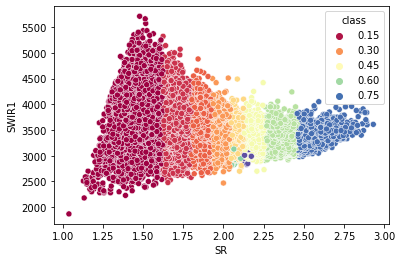

0.8544371713156047
0.8015560892449847
0.7158402429408955
0.7068504239500419
0.7876310435678003
0.8130496420265935
0.9400056230796238
0.9187560891889649
0.8578913307148153
RMSE = 2.615223463029034


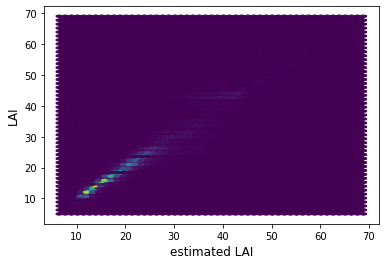

NameError: name 'RMSE_list' is not defined

In [126]:

    maxClasses=10
    numLARSFeatures=4
    maxSamples=10000
    percentilePairwiseDist=99
    metricDist='euclidean'
    randSeed=1 
    

    
    # uniform sub sample and get lars features 
    subSampleDF = subsampleSobol(calDF,allfeatures ,maxSamples,percentilePairwiseDist,metricDist,randSeed)
    alphas, active, coefs = showLarsPath(subSampleDF[allfeatures].to_numpy(),subSampleDF[response].to_numpy())
    featuresLARS = [features[i] for i in np.uint64(np.where(abs(coefs[:,numLARSFeatures])>0))[0]]
    print(featuresLARS)
    print('lars df size', subSampleDF.shape)
    
    # just for visual comparison of subsample
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.hexbin(scaledDF[featuresLARS[0]],scaledDF[response], gridsize=(50,50))
    ax1.set(xlabel=featuresLARS[0], ylabel=response)
    ax2.hexbin(subSampleDF[featuresLARS[0]],subSampleDF[response], gridsize=(50,50))
    ax2.set(xlabel=featuresLARS[0], ylabel=response)   
    plt.show()
    
    # fit RF regressor to all data and use prediction as class label
    rf = RandomForestRegressor(n_estimators=1,min_samples_leaf=100,bootstrap=False,random_state=0,verbose=0,max_leaf_nodes=maxClasses).fit(scaledDF[featuresLARS], scaledDF[response])

  

df['class'] = rf.predict(scaledDF[featuresLARS])
classValues = df['class'].unique()
numClasses = len(classValues)
print(numClasses)
seaborn.scatterplot(data=df,x='SR',y='SWIR1',hue='class',palette="Spectral")
plt.show()

# make a regression tree for each cluster and predict (for now no testing dataset ... )
# we assume for now each cluster sufficiently uniform and we use all VIs
# we coyuld always resort to lars or both but a RF is generally robust to lots of features 
YY = []
yy = []
for i in range(1,numClasses):
    X = df.loc[df['class']==classValues[i],['red','NIR','SWIR1','SR','ISR']]
    y = np.ravel(np.array(df.loc[df['class']==classValues[i],['LAI']]))
    scalerX= MinMaxScaler().fit(X)
    scaledX= pd.DataFrame(scalerX.transform(X),columns = X.columns, index =X.index)    
    clf = RandomForestRegressor(random_state=0).fit(scaledX,y)
    print(clf.score(scaledX,y))
    YY.append(clf.predict(scaledX))
    yy.append(y)
YY = [item for sublist in YY for item in sublist]
yy = [item for sublist in yy for item in sublist]
RMSE = np.sqrt(np.square(np.subtract(yy,YY)).mean())
print('RMSE =', RMSE)
plt.hexbin(YY, yy, gridsize=(50,50))
plt.xlabel('estimated LAI',size = 12)
plt.ylabel('LAI',size = 12)
plt.show()      

RMSE_list.append(RMSE)

In [106]:
df['class'] = rf.predict(scaledDF[featuresLARS])
print(df)

          year  month  day  path  row        Lat        Lon       input36  \
528215    2013      6    1   169   80 -29.360077  30.064598  2.126010e+15   
528289    2013      6    1   169   80 -29.373567  30.063421  2.126010e+15   
528367    2013      6    1   169   80 -29.391554  30.099701  2.126010e+15   
527699    2013      6    1   169   80 -29.234172  30.109998  2.126010e+15   
528140    2013      6    1   169   80 -29.342091  30.100558  2.126010e+15   
...        ...    ...  ...   ...  ...        ...        ...           ...   
10985953  2014      7    1   228   73 -18.689638 -59.225938  2.175112e+15   
10985929  2014      7    1   228   73 -18.685142 -59.224366  2.175112e+15   
10986846  2014      7    1   228   73 -18.838026 -59.259066  2.175112e+15   
10986352  2014      7    1   228   73 -18.752591 -59.243246  2.175112e+15   
10986256  2014      7    1   228   73 -18.739101 -59.233764  2.175112e+15   

               input45    inputMOD09  ...      NDWI      NDGI  NDVI3  EVI  

In [81]:
print(newSample.shape)

(2630, 51)


In [ ]:
# for each class 

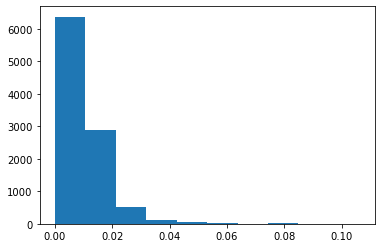

2163


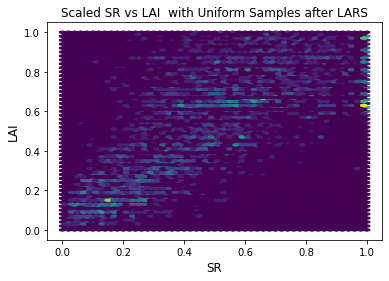

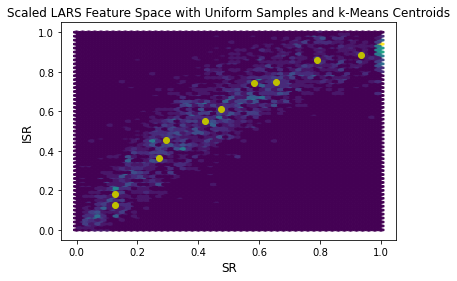

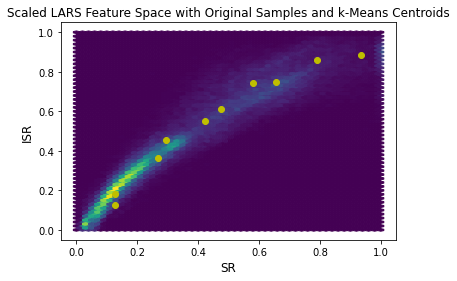

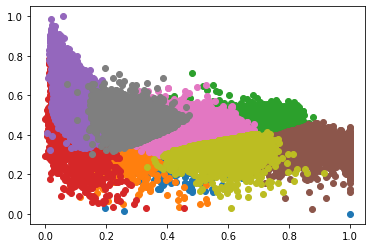

0.821801929651709
0.9182645579462657
0.7517799703349355
0.8889127576096396
0.9185413537129417
0.825709744280229
0.8156806196433962
0.9085418275536902
0.7860432656529006
RMSE = 0.037952493419897884


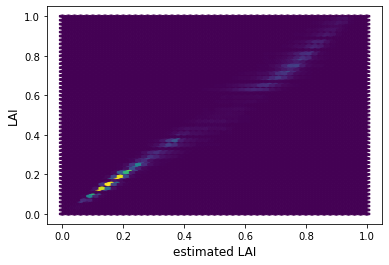

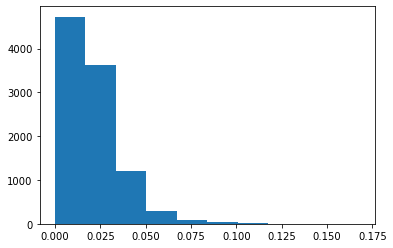

3956


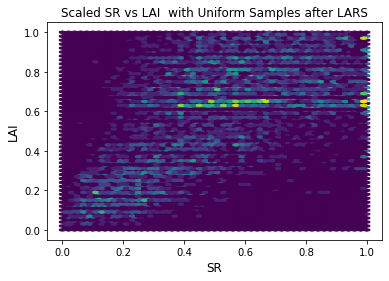

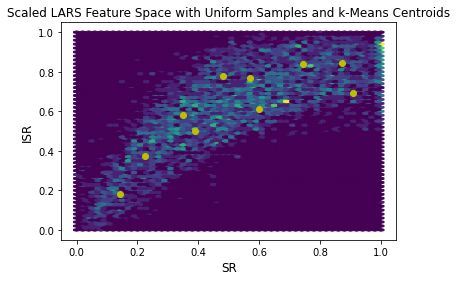

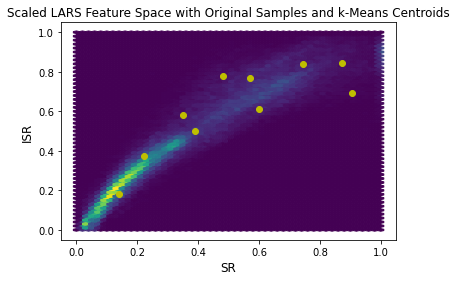

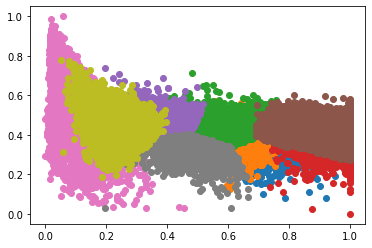

0.7536464193134249
0.8109077187996274
0.7684872813705028
0.8905549017404482
0.8554444808183669
0.7981920968187154
0.9165246235659861
0.8320731438172484
0.9139444657291985
RMSE = 0.03656531714294749


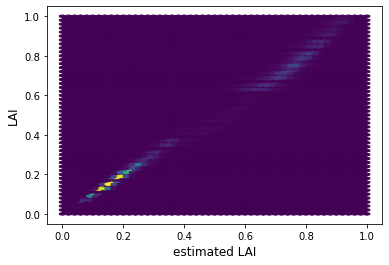

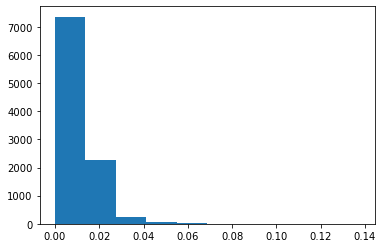

2139


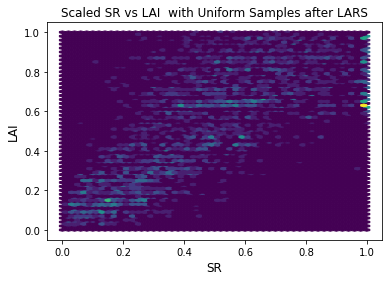

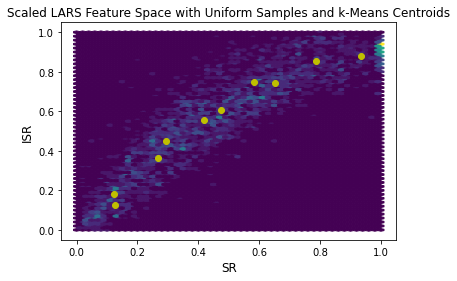

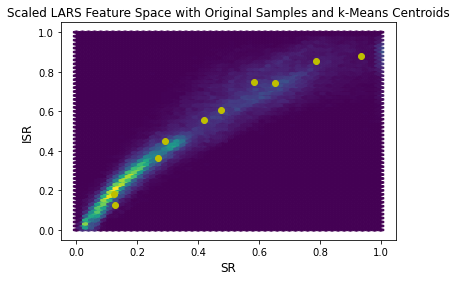

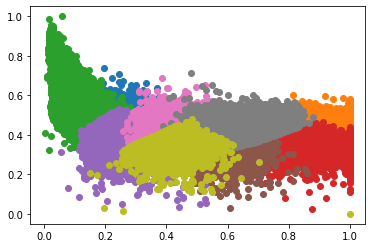

0.9079024700937379
0.8171125932203656
0.920389884303334
0.8223340489655742
0.9169345197362023
0.7842772423166878
0.818101142323891
0.7520680751721911
0.8231537697880764
RMSE = 0.03982424886949042


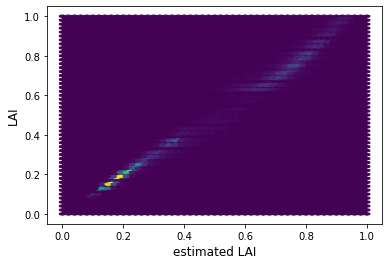

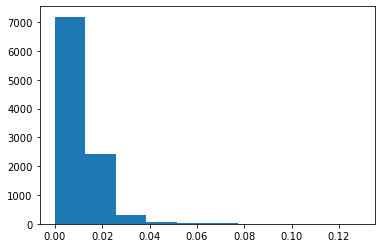

3015


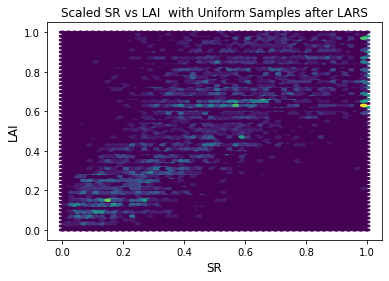

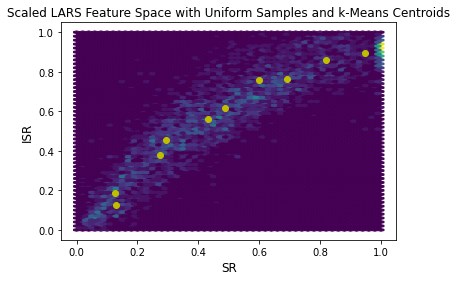

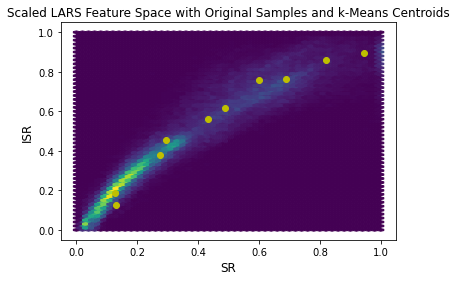

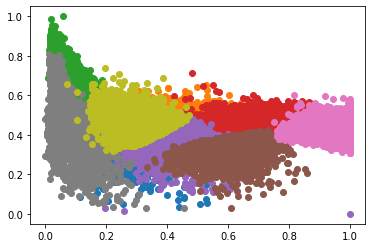

0.9158171453666178
0.8104116139482066
0.9180915362453723
0.7530146853894202
0.8205929577228193
0.7770283363579983
0.8205781998221361
0.8870852713495905
0.9111157880490166
RMSE = 0.037684956881623204


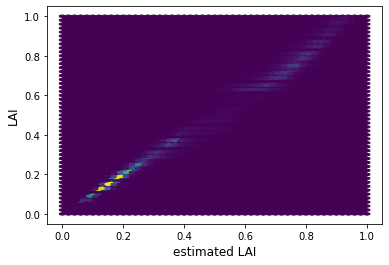

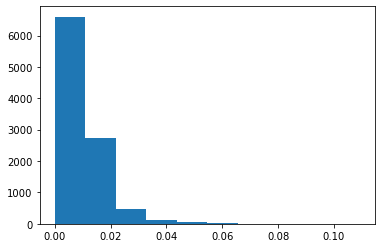

2159


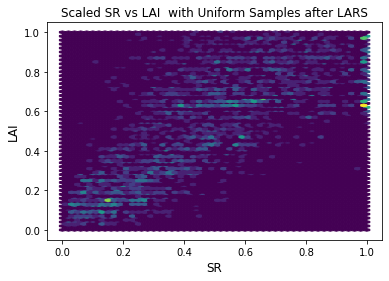

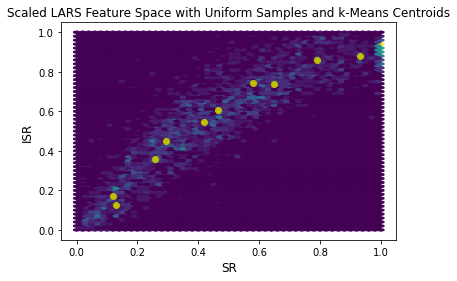

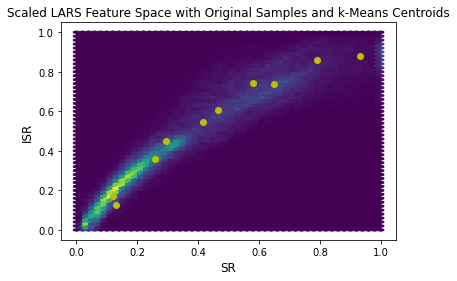

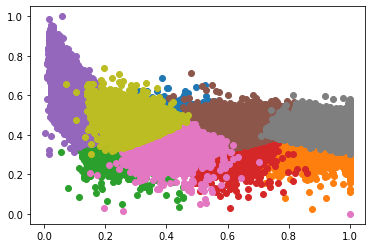

0.8211432041195107
0.8261372032121642
0.917569002468063
0.789500464376221
0.921899790110029
0.7518285004828551
0.822613311677645
0.8173608846606897
0.9036724975006484
RMSE = 0.03930276454029425


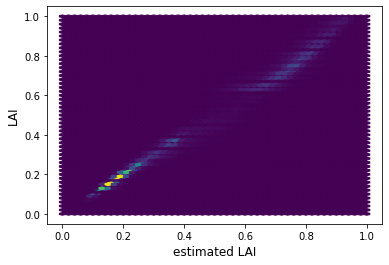

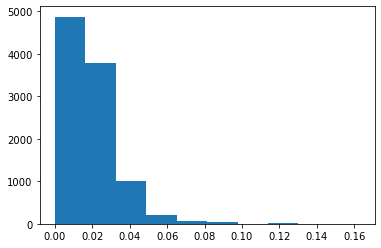

3599


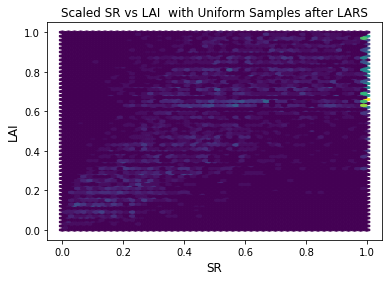

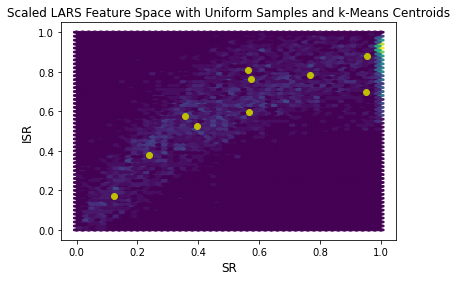

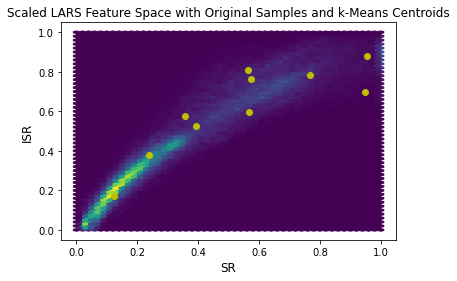

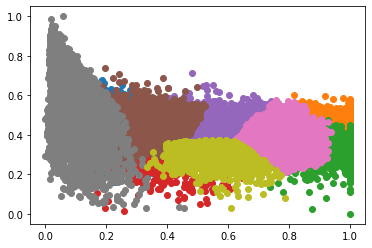

0.9146665807141177
0.8136221465351194
0.907353870739215
0.8200398666259165
0.7793758941689175
0.8600873745224445
0.76761674781643
0.9191495926355077
0.796169105815874
RMSE = 0.034048169869180085


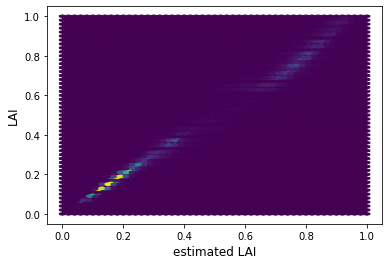

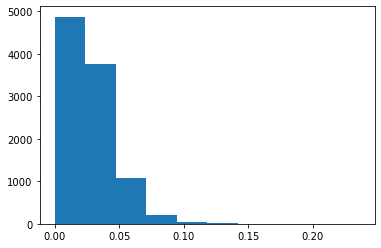

4864


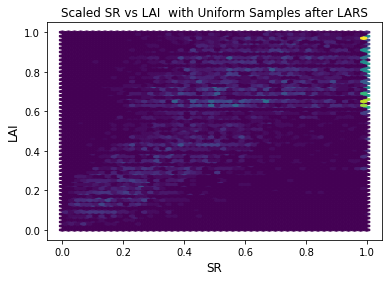

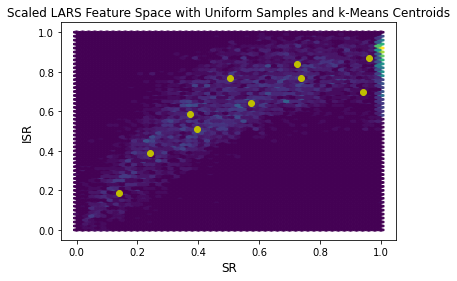

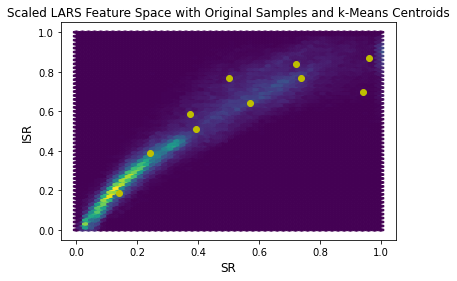

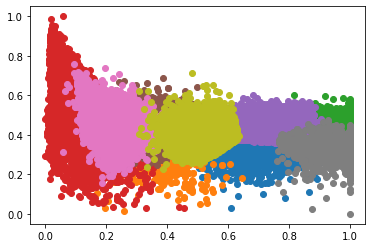

0.766590398799037
0.8218471692444387
0.8111093399282626
0.921667893480934
0.7446331296793669
0.8415158725056997
0.9120584064602753
0.8950001041292658
0.7879550311210313
RMSE = 0.034480252161533234


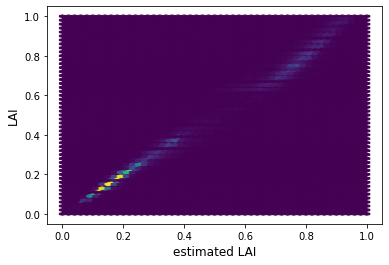

In [46]:
RMSE_list = []

for i in range(len(listVI_best)): 
               
    # do a coarse uniform subsample for lars  VIs
    featureColumns = listVI_best[i] + ['LAI']
    # get pdf of pairwise distances amd use x%ile 
    di = np.amin(pairwise_distances(scaledSample.sample(10000)[featureColumns])+np.diag(np.ones(di.shape[0])+100),axis=1)
    plt.hist(di)
    plt.show()    
    pairwiseDist = np.percentile(di,99)
    numDim = len(featureColumns)
    newSample  = scaledSample.iloc[0:1]
    leafSize = 10
    # just do one set of random samples 
    for i in range(1,2):
        newSample = pd.concat([newSample,sobolSampler(scaledSample,featureColumns,leafSize,randSeed,numDim,pairwiseDist)])
        print(len(newSample))   
    plt.hexbin(newSample['SR'],newSample['LAI'], gridsize=(50,50), extent=(0,1,0,1))
    plt.xlabel('SR',size = 12)
    plt.ylabel('LAI',size = 12)
    plt.title('Scaled SR vs LAI  with Uniform Samples after LARS')
    plt.show()    


    # do kmeans with only a M clusters on the lars subset and visualize
    numClusters = 10
    kmeans = KMeans(n_clusters=numClusters, random_state=0).fit(newSample[listVI_best[i]])
    plt.hexbin(newSample[listVI_best[i][0]],newSample[listVI_best[i][1]], gridsize=(50,50), extent=(0,1,0,1))
    plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='y')
    plt.xlabel(listVI_best[i][0],size = 12)
    plt.ylabel(listVI_best[i][1],size = 12)
    plt.title('Scaled LARS Feature Space with Uniform Samples and k-Means Centroids')
    plt.show() 

    plt.hexbin(scaledSample[listVI_best[i][0]],scaledSample[listVI_best[i][1]], gridsize=(50,50), extent=(0,1,0,1))
    plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],c='y')
    plt.xlabel(listVI_best[i][0],size = 12)
    plt.ylabel(listVI_best[i][1],size = 12)
    plt.title('Scaled LARS Feature Space with Original Samples and k-Means Centroids')
    plt.show() 
    from sklearn.ensemble import RandomForestRegressor

    # label allsamples by cluster which can now be treated as inputs for each tree
    # ideallyy we would add in a bit of adjacent cluster - not sure how to do this easily
    scaledSample['cluster1'] = kmeans.predict(scaledSample[listVI_best[i]])
    for i in range(1,numClusters):
        plt.scatter(scaledSample.loc[scaledSample['cluster1']==i]['SR'],scaledSample.loc[scaledSample['cluster1']==i]['SWIR1'])
    plt.show()


    # make a regression tree for each cluster and predict (for now no testing dataset ... )
    # we assume for now each cluster sufficiently uniform and we use all VIs
    # we coyuld always resort to lars or both but a RF is generally robust to lots of features 
    YY = []
    yy = []
    for i in range(1,numClusters):
        X = scaledSample.loc[scaledSample['cluster1']==i,['red','NIR','SWIR1','SR','ISR']]
        y = np.ravel(np.array(scaledSample.loc[scaledSample['cluster1']==i,['LAI']]))
        clf = RandomForestRegressor(random_state=0).fit(X,y)
        print(clf.score(X,y))
        YY.append(clf.predict(X))
        yy.append(y)
    YY = [item for sublist in YY for item in sublist]
    yy = [item for sublist in yy for item in sublist]
    RMSE = np.sqrt(np.square(np.subtract(yy,YY)).mean())
    print('RMSE =', RMSE)
    plt.hexbin(YY, yy, gridsize=(50,50), extent=(0,1,0,1))
    plt.xlabel('estimated LAI',size = 12)
    plt.ylabel('LAI',size = 12)
    plt.show()      
    
    RMSE_list.append(RMSE)

In [47]:
data_list = []

for j in range(len(RMSE_list)):
    data_list.append([j+2, listVI_best[j], RMSE_list[j]])
    
df = pd.DataFrame(data_list, columns = ['k', 'ListVi', 'RMSE'])
df.style.hide_index()

k,ListVi,RMSE
2,"['ISR', 'NIR1']",0.037952
3,"['SR', 'ISR', 'NIR1']",0.036565
4,"['ISR', 'NIR1']",0.039824
5,"['ISR', 'NIR1']",0.037685
6,"['ISR', 'NIR1']",0.039303
7,"['ISR', 'NIR1', 'GVI']",0.034048
8,"['ISR', 'NIR1', 'GI', 'GVI']",0.034480
